# **Import/Definicje**


In [1]:
import os
import cv2
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from torch import nn
from google.colab import drive
from skimage.feature import hog
from torchsummary import summary
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import load_img, img_to_array

In [2]:
drive.mount('/content/gdrive')
data_dir = '/content/gdrive/MyDrive/ASO_Project/'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Mounted at /content/gdrive
cpu


In [3]:
def draw_heatmap(image, preds, kernel, step):
  rows = preds.shape[0]
  cols = preds.shape[1]
  sy = kernel.shape[0]
  sx = kernel.shape[1]

  hmap = np.zeros(image.shape[2:])

  for r in range(rows):
    for c in range(cols):
      y = r * step
      x = c * step
      hmap[y:y + sy, x:x + sx] = hmap[y:y + sy, x:x + sx] + preds[r, c] * kernel

  if np.amax(hmap) > 1:
    hmap = hmap / np.amax(hmap)

  hmap2 = (hmap * 255).astype(np.uint8)

  cmap = cv2.applyColorMap(hmap2, cv2.COLORMAP_HOT)
  cmap = cmap[:, :, ::-1]
  img = (image.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
  ret = 0.3 * img + 0.7 * cmap


  return ret.astype(np.uint8)

In [4]:
def draw_overlay(img_arr, bboxes_list):
  overlay_thickness = 2
  font = cv2.FONT_HERSHEY_SIMPLEX

  for x in bboxes_list:
    start_point = (x[1][0] - x[1][2] // 2, x[1][1] - x[1][3] // 2)
    end_point = (x[1][0] + x[1][2] // 2, x[1][1] + x[1][3] // 2)
    text_start_point = (x[1][0] - x[1][2] // 2, x[1][1] - x[1][3] // 2 - 10)

    img_arr = cv2.rectangle(img_arr, start_point, end_point, 255, overlay_thickness)
    img_arr = cv2.putText(img_arr, x[0], text_start_point, font, 0.8, 255, overlay_thickness - 1, cv2.LINE_AA)

  plt.imshow(img_arr, cmap = 'gray')
  plt.axis('off')
  plt.show()

In [5]:
def IOU(bboxes1, bboxes2):
  x1A = bboxes1[0] - bboxes1[2] // 2
  y1A = bboxes1[1] - bboxes1[3] // 2
  x2A = bboxes1[0] + bboxes1[2] // 2
  y2A = bboxes1[1] + bboxes1[3] // 2

  x1B = bboxes2[0] - bboxes2[2] // 2
  y1B = bboxes2[1] - bboxes2[3] // 2
  x2B = bboxes2[0] + bboxes2[2] // 2
  y2B = bboxes2[1] + bboxes2[3] // 2

  xA = max(x1A, x1B)
  yA = max(y1A, y1B)
  xB = min(x2A, x2B)
  yB = min(y2A, y2B)

  intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

  box1_area = (x2A - x1A + 1) * (y2A - y1A + 1)
  box2_area = (x2B - x1B + 1) * (y2B - y1B + 1)

  iou = intersection_area / float(box1_area + box2_area - intersection_area)

  return iou

In [6]:
def IOU2(bboxes1, bboxes2):
  x1A = bboxes1[0] - bboxes1[2] // 2
  y1A = bboxes1[1] - bboxes1[3] // 2
  x2A = bboxes1[0] + bboxes1[2] // 2
  y2A = bboxes1[1] + bboxes1[3] // 2

  x1B = bboxes2[0]
  y1B = bboxes2[1]
  x2B = bboxes2[0] + bboxes2[2]
  y2B = bboxes2[1] + bboxes2[3]

  xA = max(x1A, x1B)
  yA = max(y1A, y1B)
  xB = min(x2A, x2B)
  yB = min(y2A, y2B)

  intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

  box1_area = (x2A - x1A + 1) * (y2A - y1A + 1)
  box2_area = (x2B - x1B + 1) * (y2B - y1B + 1)

  iou = intersection_area / float(box1_area + box2_area - intersection_area)

  return iou

In [7]:
def nms(bboxes_list, threshsold=0.2):
  final_boxes = []
  bboxes_sorted = sorted(bboxes_list, reverse=True, key=lambda x: x[2])

  while len(bboxes_sorted) > 0:
    box = bboxes_sorted.pop(0)

    for b in bboxes_sorted:
      if box[0] == b[0] and IOU(box[1], b[1]) >= threshsold:
        bboxes_sorted.remove(b)

    final_boxes.append(box)

  return final_boxes

# **Preprocessing**

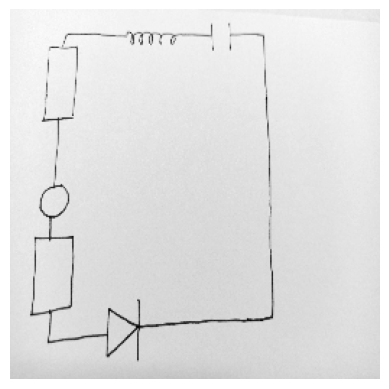

In [75]:
img_name = "18_1_resized.jpg"
img_path = data_dir + img_name
image_shapes = cv2.imread(img_path)
height, width, channels = image_shapes.shape
width_diff = width/256
height_diff = height/256
image = load_img(img_path, color_mode = "grayscale", target_size=(256, 256))
image = img_to_array(image).astype(np.float32) / 255.
plt.imshow(image[:,:, 0], cmap = 'gray')
plt.axis('off')
img = np.expand_dims(image, 0)

step = 4
sz = 32

xc = (img.shape[2] - sz) // step + 1
yc = (img.shape[1] - sz) // step + 1

hmap = np.zeros((yc, xc, 7))
img = torch.tensor(img).permute(0, 3, 1, 2)

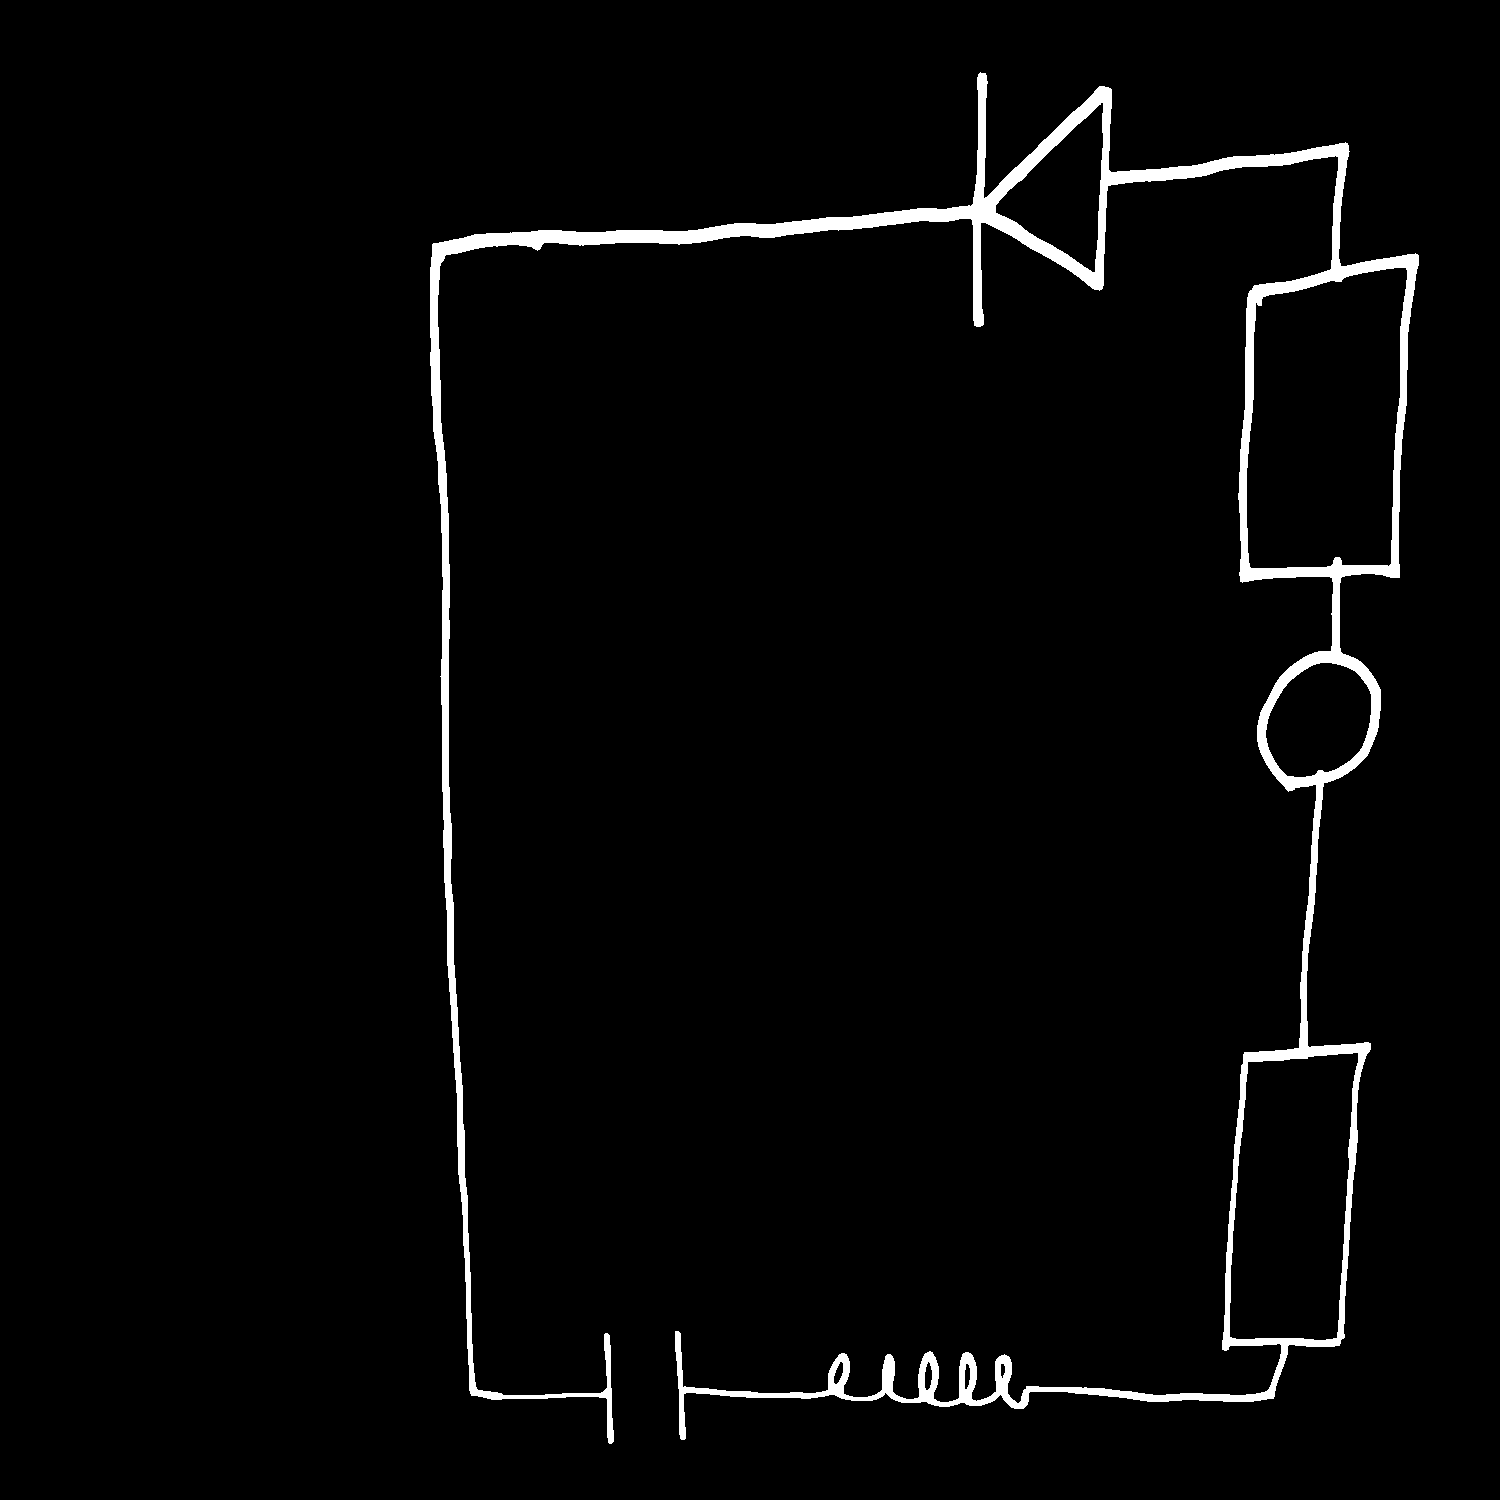

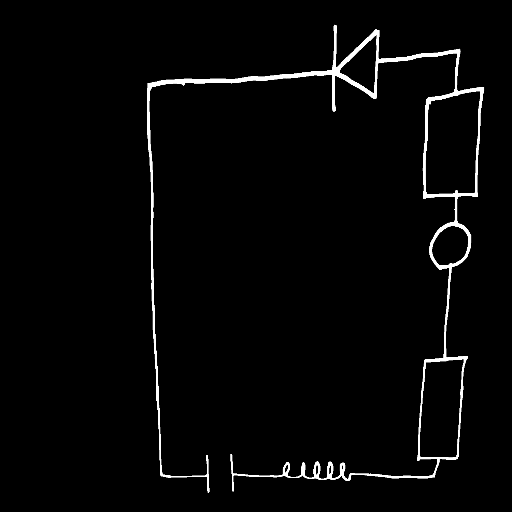

True

In [76]:
# Tu ZMIENIAC
'''
im = cv2.resize(im, (512, 512))
gray = 255 - cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

_, bw = cv2.threshold(cv2.dilate(gray, None), 250, 255, cv2.THRESH_BINARY or cv2.THRESH_OTSU)
gray = cv2.bitwise_and(gray, bw)

for row in range(gray.shape[0]):
    avg = np.average(gray[row, :] > 16)
    if avg > 0.83:
        cv2.line(gray, (0, row), (gray.shape[1] - 1, row), (0, 0, 0), 1)

for col in range(gray.shape[1]):
    avg = np.average(gray[:, col] > 16)
    if avg > 0.77:
        cv2.line(gray, (col, 0), (col, gray.shape[0] - 1), (0, 0, 0), 1)

gray = cv2.fastNlMeansDenoising(gray, None,  10, 11, 21)
st = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 1))
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, st, iterations=1)
st = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 7))
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, st, iterations=1)
_, gray = cv2.threshold(gray,10, 255, cv2.THRESH_BINARY)

# PRZERWA
'''
im = cv2.imread(img_path)
gray = 255 - cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Prepare a mask using Otsu threshold, then copy from the original. This removes some noise
__, bw = cv2.threshold(cv2.dilate(gray, None), 128, 255, cv2.THRESH_BINARY or cv2.THRESH_OTSU)
gray = cv2.bitwise_and(gray, bw)


# Scan each row and remove horizontal lines
for row in range(gray.shape[0]):
    avg = np.average(gray[row, :] > 16)
    if avg > 0.82:
        # cv2.line(im, (0, row), (gray.shape[1] - 1, row), (0, 0, 255))
        cv2.line(gray, (0, row), (gray.shape[1] - 1, row), (0, 0, 0), 1)

#cv2.imshow("gray0", gray)
# Scan each column and remove vertical lines
for col in range(gray.shape[1]):
    avg = np.average(gray[:, col] > 16)
    if avg > 0.75:
        # cv2.line(im, (col, 0), (col, gray.shape[0] - 1), (0, 0, 255))
        cv2.line(gray, (col, 0), (col, gray.shape[0] - 1), (0, 0, 0), 1)

gray = cv2.fastNlMeansDenoising(gray, None,  21, 11, 23)
st = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 1))  # Modify to link vertical residuals as well
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, st, iterations=1)
st = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 7))
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, st, iterations=1)
#gray = cv2.erode(gray, (9,9),1)
#gray = cv2.erode(gray, (3,3),1)
_, gray = cv2.threshold(gray,10, 255, cv2.THRESH_BINARY)

# DOTAD ZMIENIAC

cv2_imshow(gray)

#cv2.imshow("im", im)
gray = cv2.resize(gray, (512, 512))
cv2_imshow(gray)
gray_path = img_path[:-4] + '_gray.jpg'
cv2.imwrite(gray_path, gray)

#gray = torch.tensor(gray).permute(0, 1)


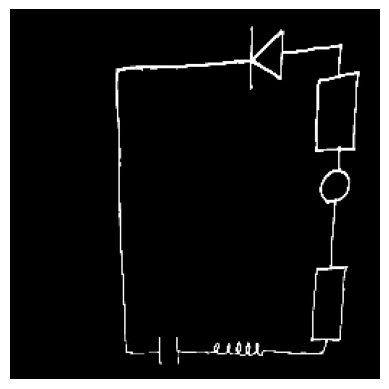

In [77]:
image = load_img(gray_path, color_mode = "grayscale", target_size=(256, 256))
image = img_to_array(image).astype(np.float32) / 255.
plt.imshow(image[:,:, 0], cmap = 'gray')
plt.axis('off')
img = np.expand_dims(image, 0)

step = 4
sz = 64
ish1 = img.shape[1]
ish2 = img.shape[2]
xc = (img.shape[2] - sz) // step + 1
yc = (img.shape[1] - sz) // step + 1

hmap = np.zeros((yc, xc, 7))
img = torch.tensor(img).permute(0, 3, 1, 2)

#**CNN**

In [20]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.batch1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act1 = nn.ReLU()

    self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    self.batch2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act2 = nn.ReLU()

    self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    self.batch3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.act3 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(4, 4))

    self.flat = nn.Flatten()

    self.lin1 = nn.Linear(256, 64)
    self.act4 = nn.ReLU()

    self.lin2 = nn.Linear(64, 7)
    self.act5 = nn.Softmax()


  def forward(self, x):
    x = self.act1(self.batch1(self.conv1(x)))
    x = self.act2(self.batch2(self.conv2(x)))
    x = self.act3(self.batch3(self.conv3(x)))
    x = self.pool(x)
    x = self.flat(x)
    x = self.act4(self.lin1(x))
    x = self.act5(self.lin2(x))

    return x

In [21]:
cnn_weights_name = "cnn"
cnn_weights_path = data_dir+cnn_weights_name
cnn_weights = torch.load(cnn_weights_path, map_location='cpu')
cnn = ConvNet()
cnn.load_state_dict(cnn_weights)

v = (1, 32, 32)
summary(cnn, input_size=v)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,088
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4            [-1, 128, 8, 8]         131,072
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]         524,288
       BatchNorm2d-8            [-1, 256, 4, 4]             512
              ReLU-9            [-1, 256, 4, 4]               0
        MaxPool2d-10            [-1, 256, 1, 1]               0
          Flatten-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [45]:
confidence = 0.95
bboxes = []
lbl_map = {0: 'C', 1: 'D', 2: 'L', 3: 'R', 4: 'S', 5: 'T', 6: 'B'}

for x in range(xc):
  for y in range(yc):
    crop = img[:, :, y * step:y * step + sz, x * step:x * step + sz]

    #CNN
    scores = cnn(crop).detach().numpy()
    hmap[y, x, :] = scores
    if max(scores[0]) > confidence:
      max_idx = np.argmax(scores[0])
      bboxes.append((lbl_map[max_idx], [x * step + sz // 2, y * step + sz // 2, sz, sz], scores[0][max_idx]))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


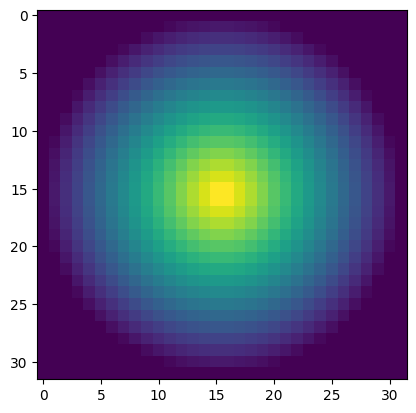

In [46]:
x_axis = np.linspace(-1, 1, sz)[:, None]
y_axis = np.linspace(-1, 1, sz)[None, :]

arr = 1 - np.sqrt(x_axis ** 2 + y_axis ** 2)
arr[arr<0] = 0
plt.imshow(arr)

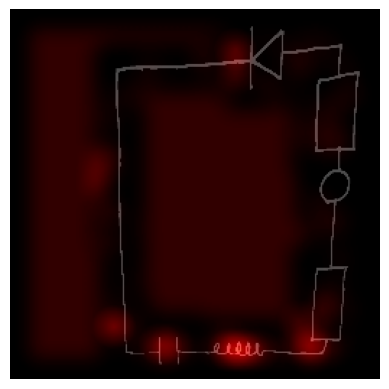

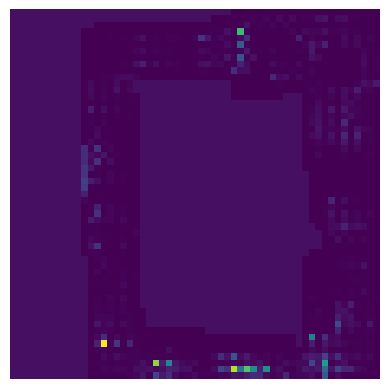

In [47]:
idx = 1
plt.imshow(draw_heatmap(img, hmap[:, :, idx], arr, step))
plt.axis('off')
plt.show()
plt.imshow(hmap[:, :, idx])
plt.axis('off')
plt.show()

In [48]:
txtfile = "18_1_resized.txt"
f = open((data_dir + txtfile), 'r')
f_data = []

for line in f:
  f_data.append(line.split(','))

f.close()
f_data = [[x[0], int(x[1]), int(x[2]), int(x[3]), int(x[4]), int(x[5])] for x in f_data]
ground_truth = [[x[2], x[3], x[4], x[5]] for x in f_data]
print(ground_truth)

[[967, 58, 154, 299], [591, 1306, 113, 160], [1237, 264, 182, 326], [1226, 1026, 149, 340], [1242, 639, 155, 165], [812, 1328, 239, 112]]


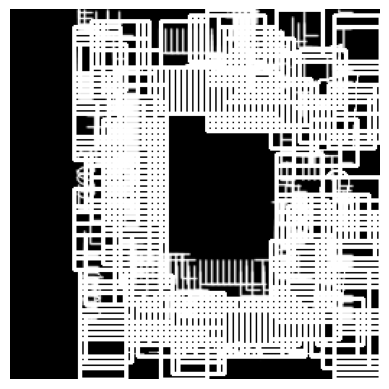

In [49]:
draw_overlay((image * 255).astype(np.uint8), bboxes)

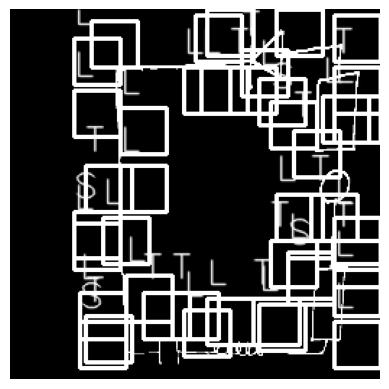

In [50]:
final = nms(bboxes, threshsold=0.01)
draw_overlay((image * 255).astype(np.uint8), final)

# **SVM**

In [78]:
svm_model = "model_thin.pkl"
svm_path = data_dir+svm_model

with open(svm_path, 'rb') as f:
    svm = pickle.load(f)
    f.close()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [79]:
confidence = 0.8
bboxes = []
lbl_map = {0: 'C', 1: 'D', 2: 'L', 3: 'R', 4: 'S', 5: 'T', 6: 'B'}

for x in range(xc):
  for y in range(yc):
    crop = img[:, :, y * step:y * step + sz, x * step:x * step + sz]

    # SVM
    fd = hog(crop.squeeze(), 9, (8, 8), (2, 2), block_norm='L2', feature_vector=True)
    scores = svm.decision_function(fd.reshape(1, -1))
    pred = svm.predict(fd.reshape(1, -1))
    scores = np.exp(scores) / np.sum(np.exp(scores), axis=1)
    hmap[y, x, :] = scores

    if max(scores[0]) > confidence and pred[0] != 'B':
      bboxes.append((svm.predict(fd.reshape(1, -1))[0],
                    [x * step + sz // 2, y * step + sz // 2, sz, sz],
                     scores[0][np.argmax(scores[0])]))

In [80]:
confidence = 0.8
sz = 32
xc = (ish2 - sz) // step + 1
yc = (ish1 - sz) // step + 1
hmap = np.zeros((yc, xc, 7))
for x in range(xc):
  for y in range(yc):
    crop = img[:, :, y * step:y * step + sz, x * step:x * step + sz]

    # SVM
    fd = hog(crop.squeeze(), 9, (4, 4), (2, 2), block_norm='L2', feature_vector=True)
    scores = svm.decision_function(fd.reshape(1, -1))
    pred = svm.predict(fd.reshape(1, -1))
    scores = np.exp(scores) / np.sum(np.exp(scores), axis=1)
    hmap[y, x, :] = scores

    if max(scores[0]) > confidence and pred[0] != 'B':
      bboxes.append((svm.predict(fd.reshape(1, -1))[0],
                    [x * step + sz // 2, y * step + sz // 2, sz, sz],
                     scores[0][np.argmax(scores[0])])),

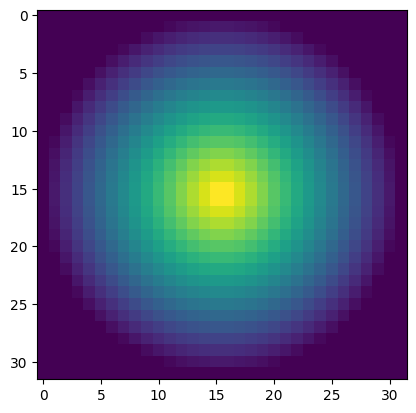

In [81]:
x_axis = np.linspace(-1, 1, sz)[:, None]
y_axis = np.linspace(-1, 1, sz)[None, :]

arr = 1 - np.sqrt(x_axis ** 2 + y_axis ** 2)
arr[arr<0] = 0
plt.imshow(arr)

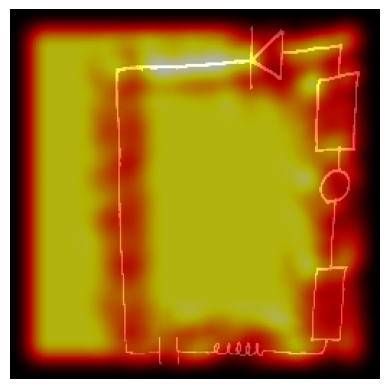

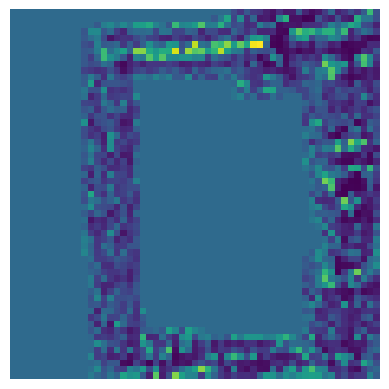

In [82]:
idx = 1
plt.imshow(draw_heatmap(img, hmap[:, :, idx], arr, step))
plt.axis('off')
plt.show()
plt.imshow(hmap[:, :, idx])
plt.axis('off')
plt.show()

In [83]:
txtfile = img_path[:-4] + '.txt'
f = open(txtfile, 'r')
f_data = []

for line in f:
  f_data.append(line.split(','))

f.close()
f_data = [(x[0], [int(x[2]), int(x[3]), int(x[4]), int(x[5])]) for x in f_data]
print(f_data)

[('D', [967, 58, 154, 299]), ('C', [591, 1306, 113, 160]), ('R', [1237, 264, 182, 326]), ('R', [1226, 1026, 149, 340]), ('S', [1242, 639, 155, 165]), ('L', [812, 1328, 239, 112])]


In [84]:
print(bboxes)

[('R', [92, 224, 64, 64], 0.8066592223212964), ('C', [164, 36, 64, 64], 0.8726690647909817), ('C', [168, 36, 64, 64], 0.9252665148474709), ('C', [172, 36, 64, 64], 0.8469596507546353), ('R', [176, 36, 64, 64], 0.8095986443114855), ('R', [216, 196, 64, 64], 0.8569031729940938), ('R', [224, 88, 64, 64], 0.8352861295479574), ('R', [64, 116, 32, 32], 0.8114329668039136), ('R', [64, 144, 32, 32], 0.822358709901397), ('R', [68, 200, 32, 32], 0.8397252907924531), ('R', [88, 232, 32, 32], 0.8051684864496688), ('R', [100, 232, 32, 32], 0.9114923198026188), ('L', [116, 228, 32, 32], 0.8132921730067902), ('C', [164, 36, 32, 32], 0.8273184302400265), ('C', [168, 36, 32, 32], 0.8421220094672845), ('R', [180, 24, 32, 32], 0.9599913159517814), ('R', [180, 28, 32, 32], 0.8968756334169168), ('R', [180, 40, 32, 32], 0.8139681023006363), ('S', [220, 128, 32, 32], 0.8167416173596267), ('R', [228, 84, 32, 32], 0.8274776201095123)]


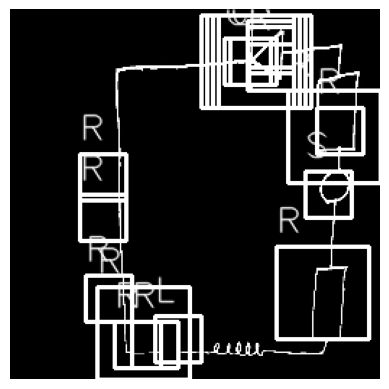

In [85]:
draw_overlay((image * 255).astype(np.uint8), bboxes)

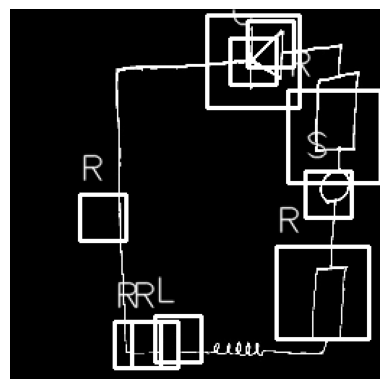

In [86]:
final = nms(bboxes, threshsold=0.0001)
draw_overlay((image * 255).astype(np.uint8), final)

## Tu dodane te recalle precision itd

In [87]:
print(final)
print(f_data)

[('R', [180, 24, 32, 32], 0.9599913159517814), ('C', [168, 36, 64, 64], 0.9252665148474709), ('R', [100, 232, 32, 32], 0.9114923198026188), ('R', [216, 196, 64, 64], 0.8569031729940938), ('C', [168, 36, 32, 32], 0.8421220094672845), ('R', [224, 88, 64, 64], 0.8352861295479574), ('R', [64, 144, 32, 32], 0.822358709901397), ('S', [220, 128, 32, 32], 0.8167416173596267), ('L', [116, 228, 32, 32], 0.8132921730067902), ('R', [88, 232, 32, 32], 0.8051684864496688)]
[('D', [967, 58, 154, 299]), ('C', [591, 1306, 113, 160]), ('R', [1237, 264, 182, 326]), ('R', [1226, 1026, 149, 340]), ('S', [1242, 639, 155, 165]), ('L', [812, 1328, 239, 112])]


In [88]:
PR_list = []
correct_boxes = []

def recall_precision(bboxes_list, ground_truth_list, threshsold=0.1):
  bboxes_sorted = sorted(bboxes_list, reverse=True, key=lambda x: x[2])
  ground_list = ground_truth_list
  for gr in ground_list:
    gr[1][0] = gr[1][0] // width_diff
    gr[1][1] = gr[1][1] // height_diff
    gr[1][2] = gr[1][2] // width_diff
    gr[1][3] = gr[1][3] // height_diff
  recall_count = 0

  while len(bboxes_sorted) > 0:
    box = bboxes_sorted.pop(0)
    correct = False

    for g in ground_list:
      if box[0] == g[0] and IOU2(box[1], g[1]) >= threshsold:
        recall_count = recall_count + 1
        correct = True
        break

    current_precision = recall_count / (len(PR_list)+1)
    current_recall = recall_count / len(f_data)
    PR_list.append([current_precision, current_recall])
    correct_boxes.append((box, correct))
  recall_score = recall_count/len(f_data)
  precision_score = recall_count/len(final)
  return recall_count, recall_score, precision_score, PR_list

In [89]:
recall_count, recall_score, precision_score, PR_list = recall_precision(final, f_data, 0.2)
print('recall = ', recall_score)
print('precision = ', precision_score)

recall =  0.5
precision =  0.3


In [90]:
print(PR_list)

[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.25, 0.16666666666666666], [0.2, 0.16666666666666666], [0.3333333333333333, 0.3333333333333333], [0.2857142857142857, 0.3333333333333333], [0.375, 0.5], [0.3333333333333333, 0.5], [0.3, 0.5]]


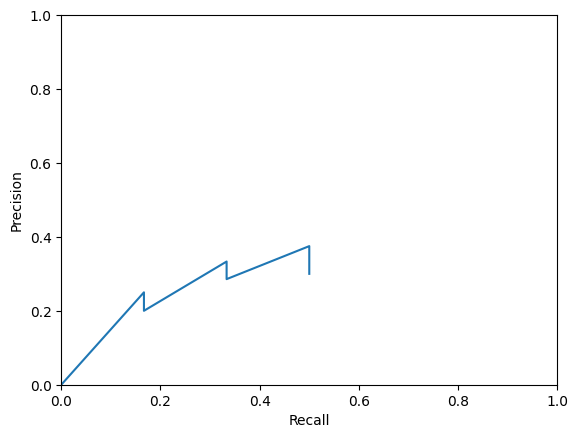

In [91]:
ax = plt.gca()
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])

x_elem = []
y_elem = []
for elem in PR_list:
  x_elem.append(elem[1])
  y_elem.append(elem[0])

plt.plot(x_elem, y_elem)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

In [92]:
def mAP(PR_list):
  precision = 0
  for elem in PR_list:
    precision = precision + elem[0]
  return precision / len(PR_list)

In [93]:
print(mAP(PR_list))

0.20773809523809522


In [94]:
print(final)

[('R', [180, 24, 32, 32], 0.9599913159517814), ('C', [168, 36, 64, 64], 0.9252665148474709), ('R', [100, 232, 32, 32], 0.9114923198026188), ('R', [216, 196, 64, 64], 0.8569031729940938), ('C', [168, 36, 32, 32], 0.8421220094672845), ('R', [224, 88, 64, 64], 0.8352861295479574), ('R', [64, 144, 32, 32], 0.822358709901397), ('S', [220, 128, 32, 32], 0.8167416173596267), ('L', [116, 228, 32, 32], 0.8132921730067902), ('R', [88, 232, 32, 32], 0.8051684864496688)]


In [95]:
scaled_boxes = []

for elem in final:
  scaled_boxes.append((elem[0], [round(elem[1][0] * width_diff), round(elem[1][1] * height_diff), round(elem[1][2] * width_diff), round(elem[1][3] * height_diff)]))
print(scaled_boxes)
out_path = img_path[:-4] + '_results.txt'
f = open(out_path, "w")
new_format = [','.join((sb[0], str(sb[1][0]), str(sb[1][1]), str(sb[1][2]), str(sb[1][3]))) for sb in scaled_boxes]

for x in new_format:
  f.write(x)
  f.write('\n')

f.close()

[('R', [1055, 141, 188, 188]), ('C', [984, 211, 375, 375]), ('R', [586, 1359, 188, 188]), ('R', [1266, 1148, 375, 375]), ('C', [984, 211, 188, 188]), ('R', [1312, 516, 375, 375]), ('R', [375, 844, 188, 188]), ('S', [1289, 750, 188, 188]), ('L', [680, 1336, 188, 188]), ('R', [516, 1359, 188, 188])]


In [96]:
print(correct_boxes)

[(('R', [180, 24, 32, 32], 0.9599913159517814), False), (('C', [168, 36, 64, 64], 0.9252665148474709), False), (('R', [100, 232, 32, 32], 0.9114923198026188), False), (('R', [216, 196, 64, 64], 0.8569031729940938), True), (('C', [168, 36, 32, 32], 0.8421220094672845), False), (('R', [224, 88, 64, 64], 0.8352861295479574), True), (('R', [64, 144, 32, 32], 0.822358709901397), False), (('S', [220, 128, 32, 32], 0.8167416173596267), True), (('L', [116, 228, 32, 32], 0.8132921730067902), False), (('R', [88, 232, 32, 32], 0.8051684864496688), False)]


In [97]:
def draw_final(img_arr, g_truth, results):
  overlay_thickness = 5
  font = cv2.FONT_HERSHEY_SIMPLEX

  for x in g_truth:
    '''
    start_point = (int((x[1][0] - x[1][2] //2) * width_diff) , int((x[1][1] - x[1][3] //2) *height_diff) )
    end_point = (int((x[1][0] + x[1][2]//2) * width_diff) , int((x[1][1] + x[1][3]//2) * height_diff) )
    text_start_point = (int((x[1][0] - x[1][2]//2) * width_diff) , int((x[1][1] - x[1][3]//2) * height_diff) - 10)
'''
    start_point = (int(x[1][0] * width_diff) , int(x[1][1]*height_diff))
    end_point = (int((x[1][0] + x[1][2]) * width_diff) , int((x[1][1] + x[1][3]) * height_diff) )
    text_start_point = (int((x[1][0]) * width_diff) , int((x[1][1]) * height_diff) - 10)

    img_arr = cv2.rectangle(img_arr, start_point, end_point, (255, 255, 255), overlay_thickness)
    img_arr = cv2.putText(img_arr, x[0], text_start_point, font, 2.0, (255, 255, 255), overlay_thickness - 1,   cv2.LINE_AA)

  for x in results:
    start_point = (int((x[0][1][0] - x[0][1][2]//2) * width_diff), int((x[0][1][1] - x[0][1][3]//2) * height_diff))
    end_point = (int((x[0][1][0] + x[0][1][2]//2) *width_diff), int((x[0][1][1] + x[0][1][3]//2) *height_diff))
    text_start_point = (int((x[0][1][0] - x[0][1][2]//2) *width_diff), int((x[0][1][1] - x[0][1][3]//2) *height_diff) - 10)
    if x[1] is True:
      rect_color = (0, 255, 0)
    else:
      rect_color = (255, 0, 0)
    img_arr = cv2.rectangle(img_arr, start_point, end_point, rect_color, overlay_thickness)
    img_arr = cv2.putText(img_arr, x[0][0], text_start_point, font, 2.0, rect_color, overlay_thickness - 1,  cv2.LINE_AA)

  cv2.imwrite(data_dir+img_name[:-4]+'_result.jpg', cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR))

  plt.imshow(img_arr, cmap = 'gray')
  plt.axis('off')
  plt.show()

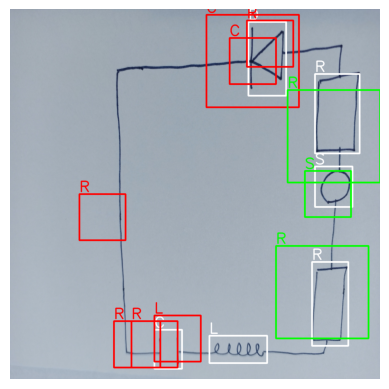

In [98]:
final_image = cv2.imread(img_path)

draw_final(final_image, f_data, correct_boxes)